# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [3]:
# # # Here is a helping code that will download and unzip the dataset for you.
# # # Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 84.3MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [4]:
!pip install skimpy
!pip install summarytools

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.


In [5]:
from summarytools import dfSummary
from skimpy import skim

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
df = pd.read_csv('/content/Traffic Data.csv', index_col=['date_time'] , parse_dates=['date_time']) #setting date time as index
df.head() #displaying data

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [8]:
dfSummary(df) #detailed summary of data

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,traffic_volume[float64],Mean (sd) : 3278.2 (1977.2)min < med < max:113.0 < 3430.0 < 16781.0IQR (CV) : 3699.2 (1.7),"5,754 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACNklEQVR4nO3dMY7aQBiG4X/iBRlQbCEk6LhApBSUHCKHTZsuBSfgBjQICRkjnHUwxmlCugQYL7E/9n1qZozQ60Egj8ZVVWVA231o+g0At3i59gLnXM/Mup7zH6uqevUcC/zxz1Cdc73RaPQliqKhz+T7/T5xzn31jZWbBBfXVtRuFEXD+Xz+Gsdxfs/EaZqGi8ViuN1uu2Z2dzBN3yRol6tf/WZmcRzn4/H4h8f8PY8xF43dJGifm0JtUkM3CVqGX/2QQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQ8NDnUcuy7JhZ5JzzGR6dz+fOG78liHpYqFmWdYqi+DydToMgCO56Qt/MrCiKsCzLT3mefzcznwen8UQeFurxeHwJw7A/m83yyWSS3Dt+tVoNl8tl/3Q6BT7Xr7mam7E5sFUevhVlMBh4bSVJksR7K0nd1dyMzYFt0/o9Uz7qruZsDmyfpwz1wnc1/43NgS3C31OQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQ8NQHotVR8yxVzlF9YzeFmqZpeO/Eh8MhNDPLsizcbDb9/zm+7rXX6/XHOmep7na7g3Pum5l5ncP6Tv2squqvn9cvfB/HoFI10IkAAAAASUVORK5CYII="">",20(0.1%)
2,temp[float64],Mean (sd) : 281.2 (12.7)min < med < max:243.4 < 281.8 < 310.1IQR (CV) : 19.9 (22.2),"3,901 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkUlEQVR4nO3dQYriQBSA4VeTVqJCggi68wIDvXDpIeawc4RZuJi1N3AnSlDMdDDG9KqhBxo1qcTUq/6/fZFa/HRi+pEyZVkK4LofXW8AeMRL1xtwlTFmICL9msvPZVm+Nbmf745Qv2CMGUwmk19RFI3rrD8ej4kx5jexNodQv9aPomi8XC7f4jjOqiw8HA7harUa7/f7vog8PVRf7wSEekMcx9l0Ov1XY+mg8c08wOc7AaH6Re2d4B5C9ZC2O8EjeD0FFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECY36OsZzQj67Xa6/J/biCUB1iO6Gf53lYFMXPLMv+iEideVRnEapbak/oi4hsNpvxer0eXi6XoI3NdYlQHVR3Qj9JEmcn9G3xYwoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUMHboZQu5zqLouiJSGSMeep1feZlqF3OdaZp2svz/HU+nwdBEFQa1fN5ntSWl6FKh3Od5/P5JQzD4WKxyGazWfKs6/rO11BFpNu5ztFoVPnaPs+T2vI6VFRj8Wz9obVTVQgVImL3bP2hzVNVCBUiYvdsLdL+qSqEiv/Uebb+pLVnbF74QwVChQqEChUIFSoQKlQgVKhAqFDB6feoFqN6jMt5xtlQbUb1GJfzj7OhisWoHuNy/nE5VBGpN6rHuJx/+DEFFQgVKhAqVGj1GZUTPtCU1kLlhA80qc2/qJzwgca0/nqKEz7QBH5MQQVChQrO/2cKelh+F+DmNwEIFY2w/S7AvW8C3A2VUTs8wua7AI98E+BmqE2M2u12u79V14qInE6nUEQkTdNwu90On7W2y2tr3ffn9W15B5vEgS3halZWAAAAAElFTkSuQmCC"">",0(0.0%)
3,rain_1h[float64],Mean (sd) : 0.0 (0.4)min < med < max:0.0 < 0.0 < 10.6IQR (CV) : 0.0 (0.1),87 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABaUlEQVR4nO3XT2oCMRiH4aSI6GYGETyMh+hhewhvIyUuqi1Iuuum1D/jov3R59km+cjiZYbU3nuBv+7pty8At5hd21BrXZZS5hPnf/TejxPPwpeLodZal+v1+nkYhtWU4YfD4bXW+iJWHnXtizofhmG13W6P4zie7hncWlvsdrvVfr+fl1KEykOu/vpLKWUcx9Nms3mbMH854Qx84zFFBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEmN2yqbW2uHdwa21xPp9npZSh1nr3xfh33nvvp58WPwF79y3yrjldnwAAAABJRU5ErkJggg=="">",0(0.0%)
4,snow_1h[float64],1. 0.0,"20,000 (100.0%)",,0(0.0%)
5,clouds_all[int64],Mean (sd) : 49.4 (39.6)min < med < max:0.0 < 75.0 < 92.0IQR (CV) : 89.0 (1.2),21 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACBElEQVR4nO3dUWriUBiG4e+0jsReJIjgJmYHLqKL7RLmwhW4A+8EkSNaw2hML0oHB6qNqcHzzbzPbTjmCC8hMcgf6roWkLqHe28AaKJ37w3g3xFCGEjqt1z+u67r3bmDhIqbCCEMRqPRc57nwzbr1+v1KoTwci5WQsWt9PM8H04mk11RFOU1C2OM2XQ6HS6Xy74kQkX3iqIox+Pxa4ulg0sHeZiChS+vqF3eIANNXQy16xtkoKmvrqid3iADTTV6mOrqBhloiocpWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCBUWCB

In [9]:
skim(df) #summary of data

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 20000  │ │ float64     │ 4     │                                                          │
│ │ Number of columns │ 7      │ │ string      │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA  ┃ NA %  ┃ mean     ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ traffic_volume    │  20 │   0.1 │     3278 │   1977 │    113 │   1229 │   3430 │   4928 │  16780 │   ▇▇▂   │  │
│ │ temp              │   0 │     0 │    281.2 │  12.66 │  243.4 │  271.9 │  281.8 │  291.8 │  310.1 │ ▁▂▇▅▇▁  │  │
│ │ rain_1h           │   0 │     0 │   0.0484 │  0.398 │      0 │      0 │      0 │      0 │   10.6 │    ▇    │  │
│ │ snow_1h           │   0 │     0 │        0 │      0 │      0 │      0 │      0 │      0 │      0 │     ▇   │  │
│ │ clouds_all        │   0 │     0 │    49.38 │  39.65 │      0 │      1 │     75 │     90 │     92 │ ▇▁▂ ▃▇  │  │
│ └───────────────────┴─────┴───────┴──────────┴────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                          ┃ NA    ┃ NA %      ┃ words per row            ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ weather_main                         │     0 │         0 │                        1 │                20000 │  │
│ │ weather_description                  │     0 │         0 │                      2.1 │                42286 │  │
│ └──────────────────────────────────────┴───────┴───────────┴──────────────────────────┴──────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

so from the data summary i found that i have 20 duplicate (i will drop them) and i found that i have missing values

In [10]:
df.drop_duplicates(inplace=True) # droping duplicated values

In [11]:
df.fillna(df[['traffic_volume']].mean() , inplace=True) #filling missing values in column (traffic_volume)

<Axes: xlabel='date_time'>

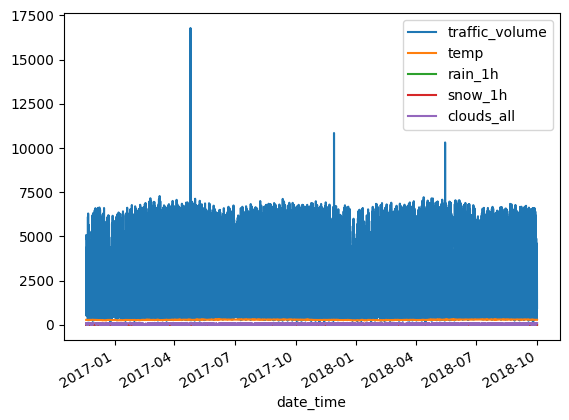

In [12]:
df.plot()

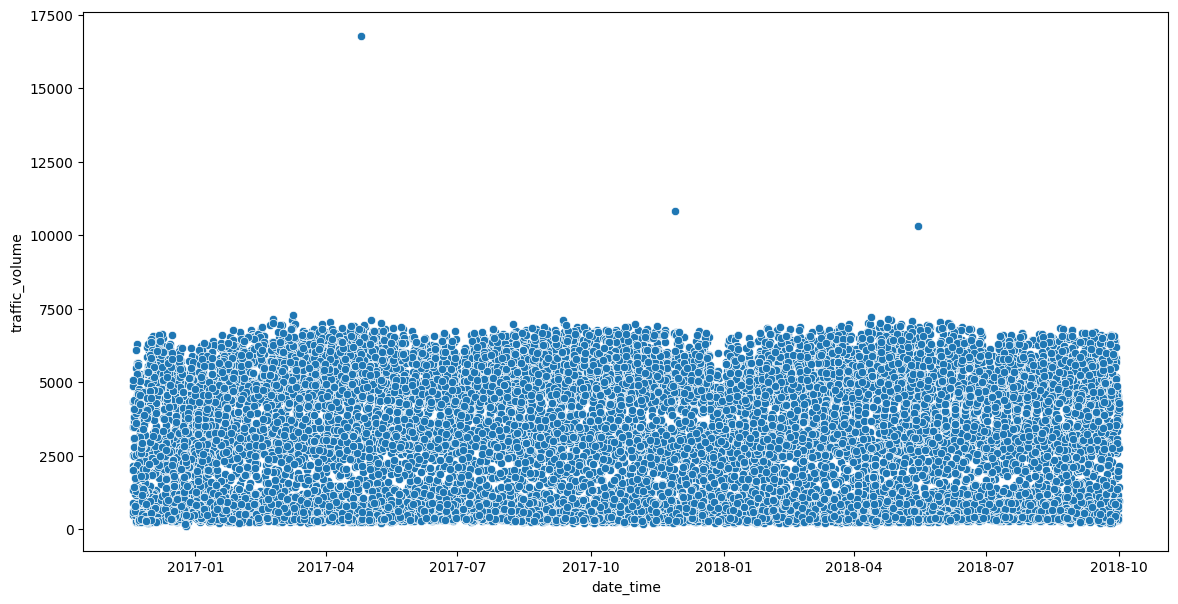

In [13]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x="date_time", y="traffic_volume")
plt.show()

<Axes: xlabel='date_time'>

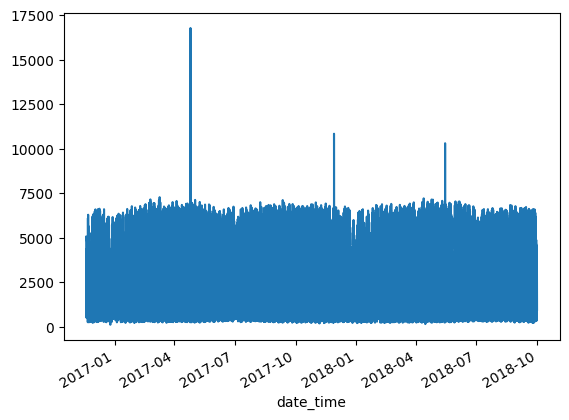

In [14]:
df['traffic_volume'].plot()

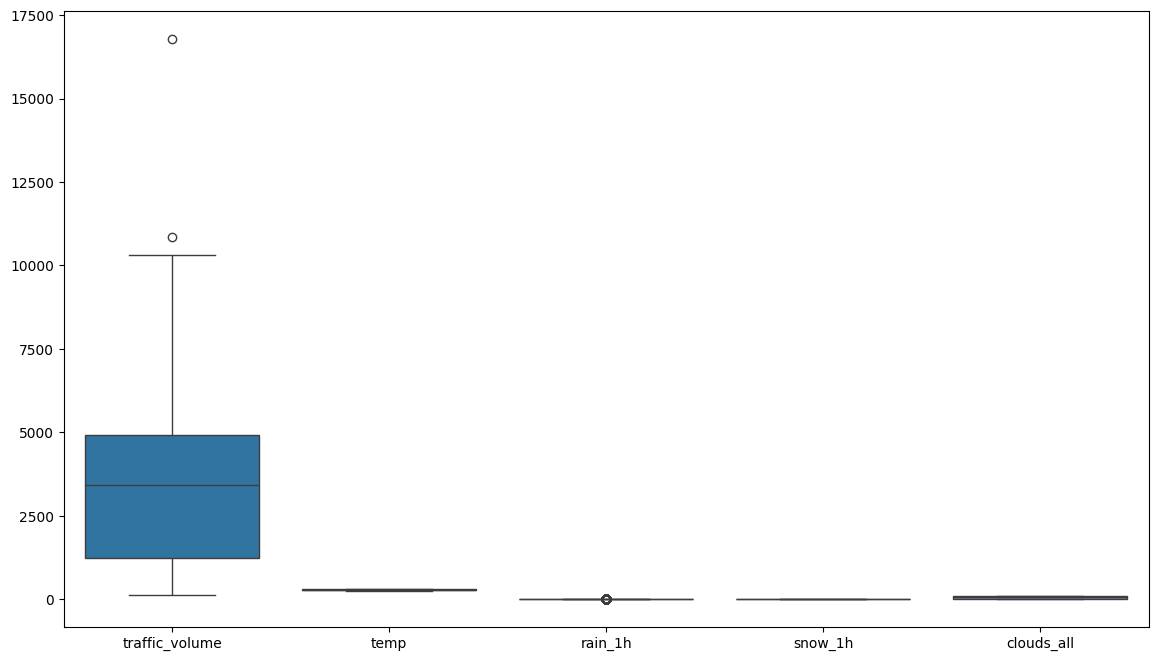

In [15]:
plt.figure(figsize=(14,8))
sns.boxplot(df)
plt.show()

<Figure size 1400x800 with 0 Axes>

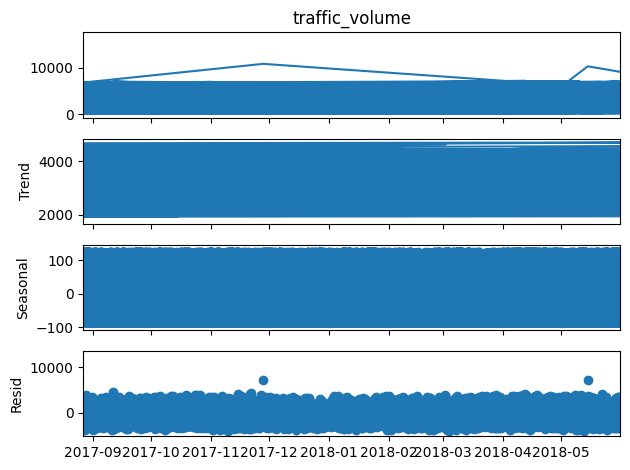

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['traffic_volume'], model='additive', period=24)
plt.figure(figsize=(14, 8))
decomposition.plot()
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [23]:
df.isnull().sum() #to check we do not have any missing values left

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [24]:
df.sort_index(inplace=True) #sorting data

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [25]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1) #Shift Method

In [26]:
df['Diff_traffic_volume'] = df['traffic_volume'].diff() #Difference between traffic_volume

In [27]:
#Date Features
df['Day_of_the_week'] = df.index.dayofweek
df['Month']= df.index.month
df['Day_of_the_year'] = df.index.dayofyear

In [28]:
df.head() #checking

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,Diff_traffic_volume,Day_of_the_week,Month,Day_of_the_year
date_time,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,NaN,NaN,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist,4872.0,0.0,4,11,323
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog,4872.0,0.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog,4872.0,202.0,4,11,323
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist,5074.0,0.0,4,11,323


In [29]:
#after i did Date Features i get Nan which i will fill them with mean again
df.fillna(df[['prev_traffic_volume']].mean() , inplace=True)
df.fillna(df[['Diff_traffic_volume']].mean() , inplace=True)

df.sort_index(inplace=True)

In [30]:
df.index

DatetimeIndex(['2016-11-18 15:00:00', '2016-11-18 15:00:00',
               '2016-11-18 15:00:00', '2016-11-18 16:00:00',
               '2016-11-18 16:00:00', '2016-11-18 16:00:00',
               '2016-11-18 17:00:00', '2016-11-18 17:00:00',
               '2016-11-18 17:00:00', '2016-11-18 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=19982, freq=None)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [31]:
#since i have categorical data i need to do label encoder
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
label_encoder = LabelEncoder()
df['weather_main'] = label_encoder.fit_transform(df['weather_main'])
df['weather_description'] = label_encoder.fit_transform(df['weather_description'])

In [57]:
# Train-Test Split
train_size = 0.8
train_index = int(len(df) * train_size)

train_df = df[:train_index]
test_df = df[train_index:]

# Select features and target
features = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'prev_traffic_volume',
            'Diff_traffic_volume', 'Day_of_the_week', 'Month', 'Day_of_the_year',
            'weather_main', 'weather_description']
target = 'traffic_volume'

X_train, X_test = train_df[features], test_df[features]
y_train, y_test = train_df[target], test_df[target]

#i will split the validation later

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [58]:
#since my data does not follow normal distribution so i will use minmax scaler

from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))


In [66]:
win = 24  #24 hours

train_scaled_df = np.hstack([y_train_scaled, X_train_scaled])
test_scaled_df = np.hstack([y_test_scaled, X_test_scaled])

batch_size = 32 #my batch size

xy_train = tf.keras.utils.timeseries_dataset_from_array(
    train_scaled_df,
    targets=train_scaled_df[win:, 0],
    sequence_length=win,
    batch_size=batch_size
)

xy_test = tf.keras.utils.timeseries_dataset_from_array(
    test_scaled_df,
    targets=test_scaled_df[win:, 0], #0 is my target column which is traffic volume
    sequence_length=win,
    batch_size=batch_size
)


total_batches = len(list(xy_train))
val_batches = int(total_batches * 0.1) #validation split

xy_val = xy_train.take(val_batches)
xy_train = xy_train.skip(val_batches)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [61]:
#setting seed so i do not get different output everytime i run the code

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)
random.seed(SEED)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [95]:
model_lstm = Sequential([
    LSTM(256, return_sequences=True, input_shape=(win, 12)),
    LSTM(290, return_sequences=False),
    Dropout(0.5),
    Dense(170, activation='relu'),
    Dense(1, activation='linear'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [96]:
model_lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

In [97]:
model_lstm.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 24, 256)             │         275,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 290)                 │         634,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 170)                 │          49,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             171 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 959,617 (3.66 MB)

 Trainable params: 959,617 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
history_lstm = model_lstm.fit(
    xy_train,
    validation_data=xy_val,
    epochs=30,
    verbose=2
)

Epoch 1/30
450/450 - 8s - 18ms/step - loss: 0.0081 - mean_absolute_error: 0.0678 - val_loss: 0.0039 - val_mean_absolute_error: 0.0500
Epoch 2/30
450/450 - 9s - 21ms/step - loss: 0.0026 - mean_absolute_error: 0.0385 - val_loss: 0.0015 - val_mean_absolute_error: 0.0299
Epoch 3/30
450/450 - 8s - 18ms/step - loss: 0.0016 - mean_absolute_error: 0.0289 - val_loss: 0.0012 - val_mean_absolute_error: 0.0265
Epoch 4/30
450/450 - 5s - 11ms/step - loss: 0.0014 - mean_absolute_error: 0.0269 - val_loss: 9.5585e-04 - val_mean_absolute_error: 0.0217
Epoch 5/30
450/450 - 5s - 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0251 - val_loss: 0.0010 - val_mean_absolute_error: 0.0232
Epoch 6/30
450/450 - 4s - 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0244 - val_loss: 0.0011 - val_mean_absolute_error: 0.0250
Epoch 7/30
450/450 - 4s - 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0236 - val_loss: 0.0010 - val_mean_absolute_error: 0.0230
Epoch 8/30
450/450 - 5s - 12ms/step - loss: 0.0011 - mean_

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [99]:
y_pred_lstm_scaled = model_lstm.predict(xy_test)


y_pred_lstm = scaler_Y.inverse_transform(y_pred_lstm_scaled)

y_test_original = np.array(list(xy_test.map(lambda x, y: y).unbatch().as_numpy_iterator()))
y_test_original = scaler_Y.inverse_transform(y_test_original.reshape(-1, 1))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [100]:
predictions_df = pd.DataFrame({
    'Actual': y_test_original(),
    'Predicted': y_pred_lstm()
})
predictions_df.to_csv('predictions_lstm.csv', index=False)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(predictions_df['Actual'], predictions_df['Predicted'])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 320.09601208067926
Mean Squared Error (MSE): 203606.7746790198
Root Mean Squared Error (RMSE): 451.22807390389596
Mean Absolute Percentage Error (MAPE): 20.911806151464177%


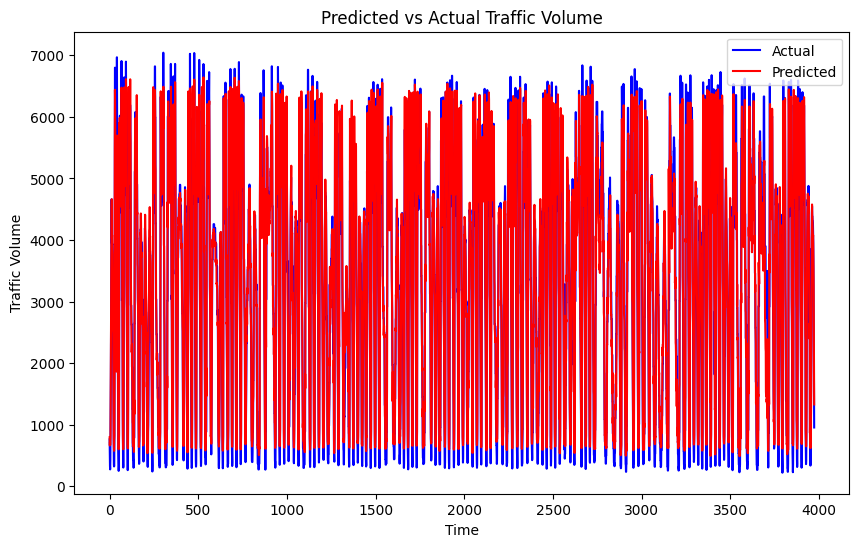

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Actual'], label='Actual', color='blue')
plt.plot(predictions_df['Predicted'], label='Predicted', color='red')
plt.title('Predicted vs Actual Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

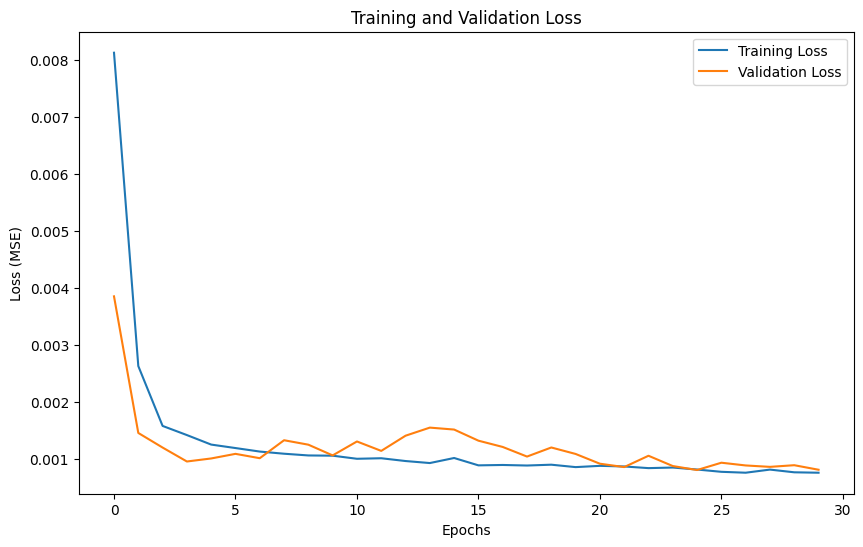

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

model_gru = Sequential([
    GRU(256, return_sequences=True, input_shape=(win, 12)),
    GRU(280, return_sequences=False),
    Dense(250, activation='relu'),
    Dropout(0.5),
    Dense(170, activation='relu'),
    Dense(1, activation='linear'),
])

In [113]:
model_gru.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

In [114]:
model_gru.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 24, 256)             │         207,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 280)                 │         451,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 250)                 │          70,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 170)                 │          42,670 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             171 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,371 (2.95 MB)

 Trainable params: 772,371 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
history_gru = model_gru.fit(
    xy_train,
    validation_data=xy_val,
    epochs=20,
    verbose=2
)

Epoch 1/20
450/450 - 71s - 158ms/step - loss: 0.0052 - mean_absolute_error: 0.0521 - val_loss: 0.0021 - val_mean_absolute_error: 0.0368
Epoch 2/20
450/450 - 4s - 10ms/step - loss: 0.0018 - mean_absolute_error: 0.0304 - val_loss: 0.0026 - val_mean_absolute_error: 0.0392
Epoch 3/20
450/450 - 5s - 11ms/step - loss: 0.0014 - mean_absolute_error: 0.0272 - val_loss: 0.0028 - val_mean_absolute_error: 0.0439
Epoch 4/20
450/450 - 10s - 22ms/step - loss: 0.0013 - mean_absolute_error: 0.0261 - val_loss: 0.0020 - val_mean_absolute_error: 0.0343
Epoch 5/20
450/450 - 7s - 15ms/step - loss: 0.0012 - mean_absolute_error: 0.0241 - val_loss: 0.0026 - val_mean_absolute_error: 0.0429
Epoch 6/20
450/450 - 5s - 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0237 - val_loss: 0.0020 - val_mean_absolute_error: 0.0359
Epoch 7/20
450/450 - 7s - 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0228 - val_loss: 0.0015 - val_mean_absolute_error: 0.0294
Epoch 8/20
450/450 - 4s - 9ms/step - loss: 0.0010 - mean_ab

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [117]:
y_pred_gru_scaled = model_gru.predict(xy_test)

# Inverse transform the predictions to return them to their original scale
y_pred_gru = scaler_Y.inverse_transform(y_pred_gru_scaled)

# Inverse transform the true test values to their original scale for comparison
y_test_original = np.array(list(xy_test.map(lambda x, y: y).unbatch().as_numpy_iterator()))
y_test_original = scaler_Y.inverse_transform(y_test_original.reshape(-1, 1))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [118]:
predictions_gru_df = pd.DataFrame({
    'Actual': y_test_original.flatten(),
    'Predicted': y_pred_gru.flatten()
})
predictions_gru_df.to_csv('predictions_gru.csv', index=True)

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae_gru = mean_absolute_error(predictions_gru_df['Actual'], predictions_gru_df['Predicted'])
print(f"Mean Absolute Error (MAE): {mae_gru}")

Mean Absolute Error (MAE): 507.80318288350065


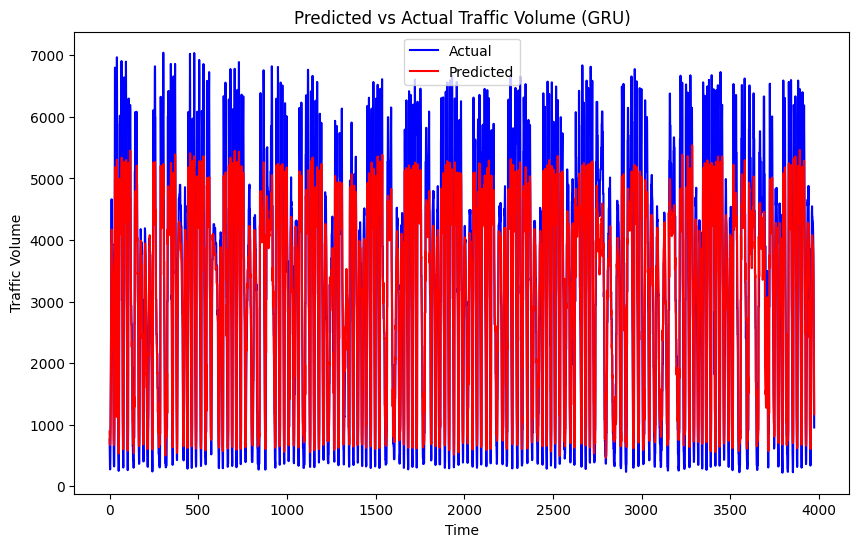

In [120]:
import matplotlib.pyplot as plt

# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(predictions_gru_df.index, predictions_gru_df['Actual'], label='Actual', color='blue')
plt.plot(predictions_gru_df.index, predictions_gru_df['Predicted'], label='Predicted', color='red')
plt.title('Predicted vs Actual Traffic Volume (GRU)')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


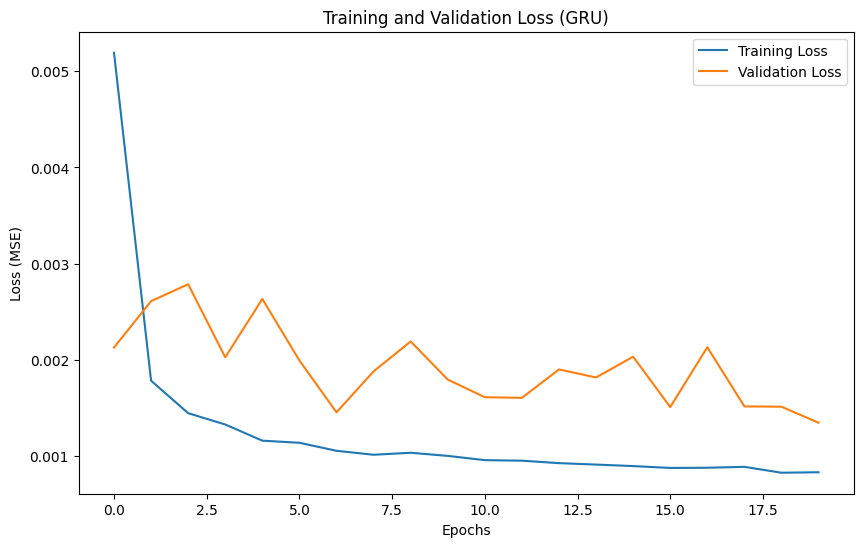

In [121]:
# Plot the loss and validation loss for the GRU model
plt.figure(figsize=(10, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1- Data Preprocessing: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?

from dfSummary i colud notic right away that i have some duplicated values and some missing value so first i droped the duplicated then i filled the missing values with mean this also from dfSummary i notieced the distribution of the data which is not normal dirtibution so i did MinMax scaler then theres some categorical columns so i did label encoding all of this helped me prepare my data to training by checking that i have clean non-duplicated data with all numrical scaled column

2- Feature Engineering: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.

yes i did , first i applyed the shift method to traffic column and i created prev_traffic_volume which display the previous day traffic

then i calculate it the difference in traffic column using function diff()

then i extracted 3 features from the column date_time (day of the week) and (month) and (day of the year)

3- Model Architecture: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?



lstm:

first layer is lstm that return squence and has input shape and 256 neurons

second layer is lstm that has 290 neurons and does not return sequnece

then dropout layer that so i can avoid overfitting

then dense layer with 170 nerions and activation function is relu

then output layer

lstm can deal with complex data and capture patterns so that why i choose it


gru:
first layer is gru that return squence and has input shape and 256 neurons

second layer is lstm that has 280 neurons and does not return sequnece

then dense layer with 250 nerions and activation function is relu

then dropout layer that so i can avoid overfitting

then dense layer with 170 nerions and activation function is relu

then output layer

gru usally is better then lstm and gives better performance


4- Training Process: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?

Batch Size (32):
it’s a commonly used size

Number of Epochs (LSTM: 30, GRU: 20):
i did not have alot of time so thats way i kept the number of epoch small also it kept gives me nan
Optimizer (Adam):
Adam is widely used because also its used for complex data

5- Loss Function and Metrics: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?

Loss Function (MSE):
mse works by focusing on large errors then smaller when also its widely used as loss fucntion


Metrics (MAE):
i have some outliers in traffic volume columns so thats why i used it

6- Model Tuning (If Done): Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?

no i did not but i adjusted the number of neurons many times

7- Overfitting and Underfitting: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?


i think its overfitting in lstm and maybe underfitting in gru

8- Future Improvements: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.



if i was given times i will try diffrent model maybe i will change number of neurons or add more layers